In [1]:
import os, shutil, gc

import hda
from getpass import getpass

import xarray as xr
import numpy as np
import cf_xarray
import rioxarray

from datetime import datetime

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import colormaps as cmo

from cartopy import crs as ccrs
from cartopy import feature as cf
from shapely import geometry
from shapely.geometry import shape

import zipfile

from rich.jupyter import print
from rich.table import Table
from rich.markdown import Markdown

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm


In [2]:
download_dir = os.path.join(os.path.expanduser('~'),"edskywalker", "downloaded-data")
result_dir = os.path.join(os.path.expanduser('~'),"edskywalker","processed-data")

os.makedirs(download_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

print(download_dir)

/home/jovyan/edskywalker/downloaded-data

In [3]:
list_flags_common = ['INLAND_WATER','CLOUD','CLOUD_AMBIGUOUS','CLOUD_MARGIN','INVALID','COSMETIC','SATURATED','SUSPECT','HISOLZEN','HIGHGLINT','SNOW_ICE']
list_flags_process = ['AC_FAIL','WHITECAPS','ADJAC','RWNEG_O2','RWNEG_O3','RWNEG_O4','RWNEG_O5','RWNEG_O6','RWNEG_O7','RWNEG_O8']
list_flags_oc4me = ['OC4ME_FAIL']
list_flags_ocnn = ['OCNN_FAIL']
list_flags_ref01 = []

def flag_data_fast(list_flag, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    for flag in list_flag:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + 'not present')
    return (flag_data & flag_bits) > 0			


In [4]:
print("Please enter your [bold u cyan]username[/bold u cyan] and [bold u cyan]password[/bold u cyan]")

print()

while True:
    try:
        user = input("Enter your WEkEO username: ")
        passw = getpass("Enter your WEkEO password: ")
        c = hda.Client(hda.Configuration(user=user, password=passw), progress=True, max_workers=1)
        print()
        print(f"Login successfull!. Your token is {c.token}.")
        break
    except KeyError:
        print()
        print('You entered wrong username and/or password.')

Please enter your username and password

Enter your WEkEO username:  edskywalker
Enter your WEkEO password:  ········


Login successfull!. Your token is 6bbaa759-d1d9-3503-8cbf-bdc4a60c540c.

In [5]:
# Satellite parameter
print("Please enter the Sentinel-3 dataset parameter. For Dataset ID, enter [bold red]1[/bold red] to choose [bold red]EO:EUM:DAT:SENTINEL-3:0556[/bold red] and [bold blue]2[/bold blue] to choose [bold blue]EO:EUM:DAT:SENTINEL-3:OL_2_WFR___[/bold blue].")
print()

while True:
    sat_id = int(input('Satellite ID: '))

    if sat_id == 1:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:0556'
        print()
        print('Dataset ID: ', dataset_id)
        break
    elif sat_id == 2:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:OL_2_WFR___'
        print()
        print('Dataset ID: ', dataset_id)
        break
    else:
        print()
        print("You put wrong number. Please try again!")


print()
print("For :satellite: satellite name, enter [bold red]a[/bold red] to choose [bold red]Sentinel-3A[/bold red] and [bold yellow]b[/bold yellow] to choose [bold yellow]Sentinel-3B[/bold yellow]. Leave it blank if you want both Sentinel-3A and Sentinel-3B queried. Please note that Sentinel-3B only available start from 18 May 2018")

sat_nm = input("Satellite name: ")

print()

if sat_nm == 'a':
    sat = 'Sentinel-3A'
    print()
    print('Satellite: ', sat)
elif sat_nm == 'b':
    sat = 'Sentinel-3B'
    print()
    print('Satellite: ', sat)
else:
    sat = ''
    print()
    print('Both Sentinel-3A and Sentinel-3B will be queried.')



Please enter the Sentinel-3 dataset parameter. For Dataset ID, enter 1 to choose EO:EUM:DAT:SENTINEL-3:0556 and 2 
to choose EO:EUM:DAT:SENTINEL-3:OL_2_WFR___.

Satellite ID:  2


Dataset ID:  EO:EUM:DAT:SENTINEL-3:OL_2_WFR___

For 📡 satellite name, enter a to choose Sentinel-3A and b to choose Sentinel-3B. Leave it blank if you want both 
Sentinel-3A and Sentinel-3B queried. Please note that Sentinel-3B only available start from 18 May 2018

Satellite name:  


Both Sentinel-3A and Sentinel-3B will be queried.

In [6]:
# Area of interest
print('Please input your :earth_asia: area of interest. The coordinates should be in [bold yellow]decimal format[/bold yellow] with :heavy_minus_sign-text: sign for south-of-equator latitude or west-of-greenwich longitude')

north = float(input('North point: ')) # -6.85
south = float(input('South point: ')) # -7.95
west = float(input('West point: ')) # 112.66
east = float(input('East point: ')) # 114.65

bbox = [west, south, east, north]
extent = [west, east, north, south]
bbox_str = f'{west},{east},{south},{north}' 

bbox_polygon = geometry.Polygon(((west,south), (west,north), (east,north), (east,south)))

print(bbox_str)

Please input your 🌏 area of interest. The coordinates should be in decimal format with ➖︎ sign for 
south-of-equator latitude or west-of-greenwich longitude

North point:  -5.2
South point:  -6.2
West point:  106.3
East point:  107.2


106.3,107.2,-6.2,-5.2

In [7]:
# Resolution in meters
resolution = 300
# Approximate conversion from meters to degrees at the equator
# (1 degree of latitude is approximately 111,320 meters)
resolution_degrees = resolution / 111320

# Calculate the number of grid points
num_lon = int(np.ceil((east - west) / resolution_degrees)) + 1
num_lat = int(np.ceil((north - south) / resolution_degrees)) + 1

# Create coordinate arrays
lon = np.linspace(west, east, num_lon)
lat = np.linspace(south, north, num_lat)

In [8]:
ds = xr.Dataset(
    coords={
        "lon": (["lon"], lon),
        "lat": (["lat"], lat),
    }
)

ds.lat.attrs = {
    'units' : 'degrees_north',
    'unit_long' : "Degrees North",
    'standard_name' : "latitude",
    'long_name' : "Latitude",
    'axis' : 'Y'
}

ds.lon.attrs = {
    'units' : 'degrees_east',
    'unit_long' : "Degrees East",
    'standard_name' : "longitude",
    'long_name' : "Longitude",
    'axis' : 'X'
}

ds["data"] = (["lat", "lon"], np.zeros((num_lat, num_lon)))

ds.rio.write_crs('epsg:4326', inplace=True)

ds.to_netcdf('grid_data.nc')
os.system("cdo griddes grid_data.nc > gridfile.txt")
os.system("cdo griddes grid_data_rep.nc > gridfile_rep.txt")

with open('gridfile.txt', 'r') as file:  # Open in read mode
    content = file.read()

print(content)

#
# gridID 1
#
gridtype  = lonlat
gridsize  = 124955
xsize     = 335
ysize     = 373
xname     = lon
xlongname = "Longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "Latitude"
yunits    = "degrees_north"
xfirst    = 106.3
xinc      = 0.00269461077844313
yfirst    = -6.2
yinc      = 0.00268817204301075

In [9]:
## Time of interest
print("Please input your :spiral_calendar: [u]date of interest[/u]. The dates should be in [bold yellow]YYYY-MM-DD[/bold yellow] format.")
print()
dtstart = input('Time start: ')
dtend = input('Time end: ')

Please input your 🗓 date of interest. The dates should be in YYYY-MM-DD format.

Time start:  2023-08-27
Time end:  2023-08-30


In [10]:
query = {
  "dataset_id": dataset_id, 
  "dtstart": dtstart,
  "dtend": dtend,
  "bbox": bbox,
  "sat": sat,
  "type": "OL_2_WFR___",
  "timeliness": "NT"
}

query_tab = Table(title="Search Query")
query_tab.add_column('Parameter', style='cyan')
query_tab.add_column('Value', style='bright_green')

for col1, col2 in query.items():
    query_tab.add_row(str(col1), str(col2))

print(query_tab)

                   Search Query                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter  ┃ Value                             ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dataset_id │ EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ │
│ dtstart    │ 2023-08-27                        │
│ dtend      │ 2023-08-30                        │
│ bbox       │ [106.3, -6.2, 107.2, -5.2]        │
│ sat        │                                   │
│ type       │ OL_2_WFR___                       │
│ timeliness │ NT                                │
└────────────┴───────────────────────────────────┘

In [11]:
print(Markdown('Please select type of data you want to download. Enter `1` to download geophysical (chlorophyll-a and total suspended matter) or enter `2` to download water surface reflectances.'))

while True:
    parameters = int(input('Parameters: '))

    if parameters == 1:
        print('Geophysical data will be processed.')
        break
    elif parameters == 2:
        print('Reflectance data will be processed.')
        break
    else:
        print("You put wrong number. Please try again!")

Please select type of data you want to download. Enter 1 to download geophysical (chlorophyll-a and total suspended
matter) or enter 2 to download water surface reflectances.

Parameters:  2


Reflectance data will be processed.

In [12]:
search_result = c.search(query)
print(search_result)


SearchResults[items=5,volume=2.5GB]

In [13]:
file_id = search_result[0].results[0]['id']
search_result[0].download()

with zipfile.ZipFile(file_id + '.zip', 'r') as zip_ref:
    zip_ref.extractall(download_dir)
#    print(f'Unzipping of product {file_id} finished.')
    os.remove(file_id + '.zip')

filedir = os.path.join(download_dir, file_id)
geo_coords = xr.open_dataset(filedir + '/geo_coordinates.nc')

flag_file = xr.open_dataset(filedir + '/wqsf.nc')
flag_names = flag_file['WQSF'].flag_meanings.split(' ') #flag names
flag_vals = flag_file['WQSF'].flag_masks #flag bit values
flags_data = flag_file.variables['WQSF'].data

start = datetime.strptime(search_result[0].results[0]['properties']['startdate'], '%Y-%m-%dT%H:%M:%S%fZ')
end = datetime.strptime(search_result[0].results[0]['properties']['enddate'], '%Y-%m-%dT%H:%M:%S%fZ')
timestamp = start + (end - start) / 2

dta = xr.Dataset()
dta['longitude'] = geo_coords['longitude']
dta['latitude'] = geo_coords['latitude']

geo_coords.close()
flag_file.close()
gc.collect()


34

In [14]:
if parameters == 1:
    keys = ["chl_nn","tsm_nn","chl_oc4me"]
    for k in keys:
        if not k == 'chl_oc4me':
            list_flags = list_flags_common + list_flags_ocnn
        else:
            list_flags = list_flags_common + list_flags_process + list_flags_oc4me

        ds = xr.open_dataset(os.path.join(filedir,f'{k}.nc'))
        dtarr = ds[str(k.upper())].data
        flag_mask = flag_data_fast(list_flags, flag_names, flag_vals, flags_data, flag_type='WQSF')
        
        flagged = np.where(flag_mask, np.nan, dtarr)
        
        dta[str(k)] = xr.DataArray(flagged, dims=('rows','columns'))
        dta[str(k)].attrs = ds[str(k.upper())].attrs

    filename = '_geo'
elif parameters == 2:
    keys = ['Oa01_reflectance','Oa02_reflectance','Oa03_reflectance','Oa04_reflectance','Oa05_reflectance','Oa06_reflectance','Oa07_reflectance','Oa08_reflectance','Oa09_reflectance','Oa10_reflectance','Oa11_reflectance','Oa12_reflectance','Oa16_reflectance','Oa17_reflectance','Oa18_reflectance','Oa21_reflectance']
    list_flags = list_flags_common + list_flags_process
    for k in keys:
        ds = xr.open_dataset(os.path.join(filedir,f'{k}.nc'))
        dtarr = ds[str(k)].data
        flag_mask = flag_data_fast(list_flags, flag_names, flag_vals, flags_data, flag_type='WQSF')
        
        flagged = np.where(flag_mask, np.nan, dtarr)
        
        dta[str(k)] = xr.DataArray(flagged, dims=('rows','columns'))
        dta[str(k)].attrs = ds[str(k)].attrs

    filename = '_ref'

dta = dta.set_coords(['latitude','longitude'])
dta = dta.expand_dims(dim={"time":[timestamp]}, axis=0)

dta = dta.cf.add_bounds(['latitude','longitude'])

In [15]:
display(dta)

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1, rows: 4090, columns: 4865, bounds: 4)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-08-30T02:37:34.600000
    longitude         (rows, columns) float64 159MB 102.0 102.0 ... 111.2 111.2
    latitude          (rows, columns) float64 159MB -0.1188 -0.1194 ... -13.33
    latitude_bounds   (rows, columns, bounds) float64 637MB -0.1173 ... -13.33
    longitude_bounds  (rows, columns, bounds) float64 637MB 102.0 ... 111.2
Dimensions without coordinates: rows, columns, bounds
Data variables: (12/16)
    Oa01_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa02_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa03_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa04_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa05_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa06_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    ...                ...
    Oa11_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa12_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa16_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa17_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa18_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan
    Oa21_reflectance  (time, rows, columns) float32 80MB nan nan nan ... nan nan

In [16]:
reggrid = cdo.sellonlatbox(bbox_str, input = dta, returnXDataset = True)

comp = dict(zlib=True, _FillValue=-99999.0, complevel=4)
encoding = {var: comp for var in reggrid.data_vars}

reggrid.to_netcdf(
    os.path.join(download_dir , file_id + str(filename) + '.nc'),
    format='NETCDF4', 
    unlimited_dims=['time'],
    encoding=encoding
)

dataset = xr.open_dataset(os.path.join(download_dir , file_id + str(filename) + '.nc'), decode_coords="all")

display(dataset)

cdo.cleanTempDir()


<xarray.Dataset> Size: 29MB
Dimensions:           (time: 1, rows: 440, columns: 451, bounds: 4)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-08-30T02:37:34.600000
    longitude         (rows, columns) float64 2MB ...
    longitude_bnds    (rows, columns, bounds) float64 6MB ...
    latitude          (rows, columns) float64 2MB ...
    latitude_bnds     (rows, columns, bounds) float64 6MB ...
Dimensions without coordinates: rows, columns, bounds
Data variables: (12/16)
    Oa01_reflectance  (time, rows, columns) float32 794kB ...
    Oa02_reflectance  (time, rows, columns) float32 794kB ...
    Oa03_reflectance  (time, rows, columns) float32 794kB ...
    Oa04_reflectance  (time, rows, columns) float32 794kB ...
    Oa05_reflectance  (time, rows, columns) float32 794kB ...
    Oa06_reflectance  (time, rows, columns) float32 794kB ...
    ...                ...
    Oa11_reflectance  (time, rows, columns) float32 794kB ...
    Oa12_reflectance  (time, rows, columns) float32 794kB ...
    Oa16_reflectance  (time, rows, columns) float32 794kB ...
    Oa17_reflectance  (time, rows, columns) float32 794kB ...
    Oa18_reflectance  (time, rows, columns) float32 794kB ...
    Oa21_reflectance  (time, rows, columns) float32 794kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 14 02:06:41 2024: cdo -O -s -f nc -sellonlatbox,106...
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

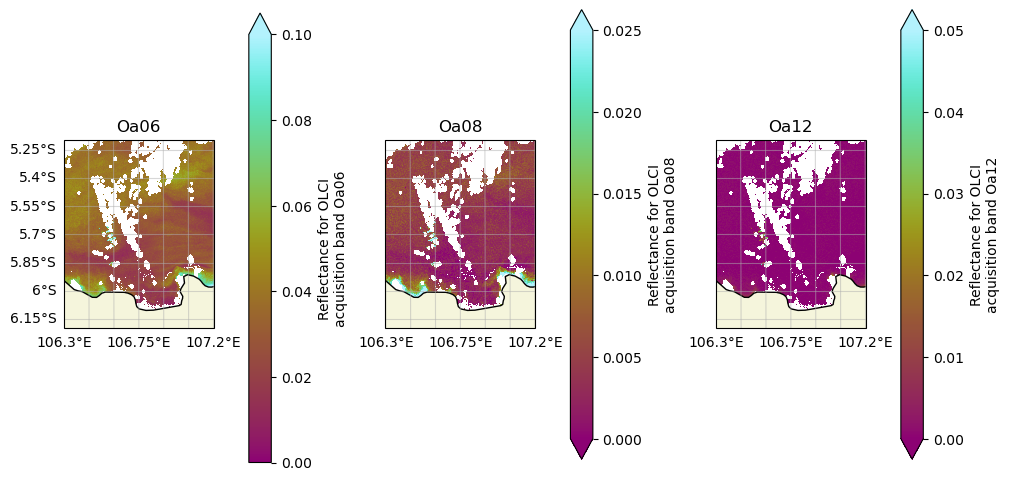

In [17]:
fig, ax = plt.subplots(figsize=[10,6], ncols = 3, layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

for i in range(3):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cf.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
#    ax[i].coastlines()
    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels = False

if parameters == 1:    
    cnn_plot = 10 ** dataset['chl_nn']
    coc_plot = 10 ** dataset['chl_oc4me']
    tsm_plot = 10 ** dataset['tsm_nn']
    
    cnn_plot.plot(ax=ax[0], x='longitude', y='latitude', add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Chlorophyll-a NN")
    coc_plot.plot(ax=ax[1], x='longitude', y='latitude', add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Chlorophyll-a OC4ME")
    tsm_plot.plot(ax=ax[2], x='longitude', y='latitude', add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.matter, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Total Suspended Matter NN")
    
    cbar1 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.algae), shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Chlorophyll-a Concentration',ax=ax[0:2])
    cbar2 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.matter), shrink=0.7, aspect=20, pad=0.02, orientation = 'horizontal', label = 'Total Suspended Matter',ax=ax[2:])

else:
    a06_plot = dataset['Oa06_reflectance']
    a08_plot = dataset['Oa08_reflectance']
    a12_plot = dataset['Oa12_reflectance']
    
    a06_plot.plot(ax=ax[0], x='longitude', y='latitude', add_colorbar=True, norm=colors.Normalize(0,0.1), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Oa06")
    a08_plot.plot(ax=ax[1], x='longitude', y='latitude', add_colorbar=True, norm=colors.Normalize(0,0.025), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Oa08")
    a12_plot.plot(ax=ax[2], x='longitude', y='latitude', add_colorbar=True, norm=colors.Normalize(0,0.05), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Oa12")

    

In [18]:
reggridded = cdo.remapcon('gridfile.txt', input = dataset, returnXDataset = True)

comp = dict(zlib=True, _FillValue=-99999.0, complevel=4)
encoding = {var: comp for var in reggridded.data_vars}

reggridded.to_netcdf(
    os.path.join(result_dir , file_id + str(filename) + '.nc'),
    format='NETCDF4', 
    unlimited_dims=['time'],
    encoding=encoding
)

dataset = xr.open_dataset(os.path.join(result_dir , file_id + str(filename) + '.nc'), decode_coords="all")

display(dataset)

cdo.cleanTempDir()

<xarray.Dataset> Size: 8MB
Dimensions:           (time: 1, lon: 335, lat: 373)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-08-30T02:37:34.600000
  * lon               (lon) float64 3kB 106.3 106.3 106.3 ... 107.2 107.2 107.2
  * lat               (lat) float64 3kB -6.2 -6.197 -6.195 ... -5.203 -5.2
Data variables: (12/16)
    Oa01_reflectance  (time, lat, lon) float32 500kB ...
    Oa02_reflectance  (time, lat, lon) float32 500kB ...
    Oa03_reflectance  (time, lat, lon) float32 500kB ...
    Oa04_reflectance  (time, lat, lon) float32 500kB ...
    Oa05_reflectance  (time, lat, lon) float32 500kB ...
    Oa06_reflectance  (time, lat, lon) float32 500kB ...
    ...                ...
    Oa11_reflectance  (time, lat, lon) float32 500kB ...
    Oa12_reflectance  (time, lat, lon) float32 500kB ...
    Oa16_reflectance  (time, lat, lon) float32 500kB ...
    Oa17_reflectance  (time, lat, lon) float32 500kB ...
    Oa18_reflectance  (time, lat, lon) float32 500kB ...
    Oa21_reflectance  (time, lat, lon) float32 500kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 14 02:06:57 2024: cdo -O -s -f nc -remapcon,gridfil...
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

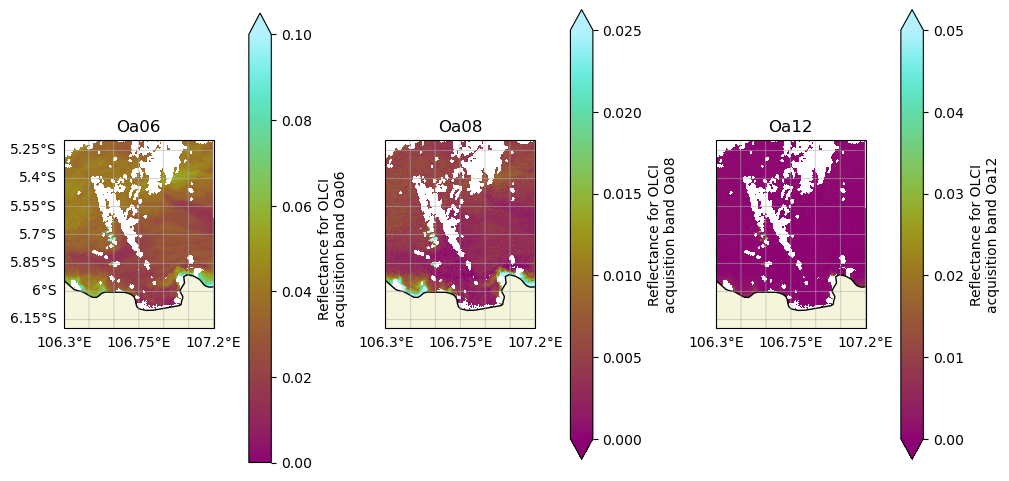

In [20]:
fig, ax = plt.subplots(figsize=[10,6], ncols = 3, layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

for i in range(3):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cf.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
#    ax[i].coastlines()
    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels = False

if parameters == 1:    
    cnn_plot = 10 ** dataset['chl_nn']
    coc_plot = 10 ** dataset['chl_oc4me']
    tsm_plot = 10 ** dataset['tsm_nn']
    
    cnn_plot.plot(ax=ax[0], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Chlorophyll-a NN")
    coc_plot.plot(ax=ax[1], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Chlorophyll-a OC4ME")
    tsm_plot.plot(ax=ax[2], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.matter, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Total Suspended Matter NN")
    
    cbar1 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.algae), shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Chlorophyll-a Concentration',ax=ax[0:2])
    cbar2 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.matter), shrink=0.7, aspect=20, pad=0.02, orientation = 'horizontal', label = 'Total Suspended Matter',ax=ax[2:])

else:
    a06_plot = dataset['Oa06_reflectance']
    a08_plot = dataset['Oa08_reflectance']
    a12_plot = dataset['Oa12_reflectance']
    
    a06_plot.plot(ax=ax[0], add_colorbar=True, norm=colors.Normalize(0,0.1), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Oa06")
    a08_plot.plot(ax=ax[1], add_colorbar=True, norm=colors.Normalize(0,0.025), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Oa08")
    a12_plot.plot(ax=ax[2], add_colorbar=True, norm=colors.Normalize(0,0.05), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Oa12")

    

In [21]:
gc.collect()

for allitem in os.listdir(download_dir):
    path = os.path.join(download_dir,allitem)
    if os.path.isfile(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)
